In [103]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import accuracy_score
import operator
from timeit import default_timer as timer
from src.main import convert_to_one_hot
from src.main import prepare_attribut_data, prepare_result_data
from src.main import DRAW, HOME_WINS, AWAY_WINS
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


In [104]:
#HYPER_PARAMS:
scaling=True
max_iter_list = [500]
solver_list = ['lbfgs']  # sag and saga take a lot of time
regularization_factor_list = [ 0.001]

In [105]:

train_path_away = '../data/Train_Data/train_away_team_statistics_df.csv'
train_path_home = '../data/Train_Data/train_home_team_statistics_df.csv'
train_path_result = '../data/Train_Data/Y_train.csv'
df_attribut = prepare_attribut_data(train_path_away, train_path_home,use_player_data=True).drop(['ID'], axis=1)
df_result = prepare_result_data(train_path_result)

In [106]:
df_attribut.head()

,HOME_TEAM_SHOTS_TOTAL_season_sum,HOME_TEAM_SHOTS_INSIDEBOX_season_sum,HOME_TEAM_SHOTS_OFF_TARGET_season_sum,HOME_TEAM_SHOTS_ON_TARGET_season_sum,HOME_TEAM_SHOTS_OUTSIDEBOX_season_sum,HOME_TEAM_PASSES_season_sum,HOME_TEAM_SUCCESSFUL_PASSES_season_sum,HOME_TEAM_SAVES_season_sum,HOME_TEAM_CORNERS_season_sum,HOME_TEAM_FOULS_season_sum,...,HOME_PLAYER_STARTING_LINEUP_5_last_match_std,HOME_PLAYER_SUCCESSFUL_DRIBBLES_5_last_match_std,HOME_PLAYER_TACKLES_5_last_match_std,HOME_PLAYER_TOTAL_CROSSES_5_last_match_std,HOME_PLAYER_TOTAL_DUELS_5_last_match_std,HOME_PLAYER_YELLOWCARDS_5_last_match_std,HOME_PLAYER_PUNCHES_5_last_match_std,HOME_PLAYER_LONG_BALLS_5_last_match_std,HOME_PLAYER_LONG_BALLS_WON_5_last_match_std,HOME_PLAYER_SHOTS_OFF_TARGET_5_last_match_std
0,3.0,2.0,5.0,2.0,1.0,2.0,2.0,5.0,3.0,6.0,...,623.0,409.0,431.0,250.0,666.0,710.0,0.0,0.0,0.0,0.0
1,6.0,8.0,3.0,6.0,5.0,8.0,7.0,10.0,6.0,8.0,...,63.0,180.0,245.0,156.0,397.0,357.0,0.0,0.0,0.0,0.0
2,4.0,2.0,5.0,2.0,8.0,1.0,1.0,2.0,2.0,7.0,...,1180.0,286.0,527.0,252.0,774.0,805.0,0.0,0.0,0.0,0.0
3,7.0,5.0,5.0,6.0,6.0,9.0,9.0,2.0,2.0,0.0,...,357.0,159.0,344.0,307.0,353.0,280.0,0.0,0.0,0.0,0.0
4,3.0,3.0,2.0,3.0,4.0,4.0,3.0,4.0,4.0,7.0,...,329.0,327.0,414.0,262.0,376.0,248.0,0.0,0.0,0.0,0.0


In [107]:
df_result.head()

,result
0,-2
1,-1
2,-2
3,1
4,-1


In [108]:

attribut_train, attribut_test, result_train, result_test = train_test_split(df_attribut, df_result, test_size=0.1,
                                                                            random_state=10)


In [109]:
result_test

,result
11028,1
10284,-2
10177,1
7139,1
937,-2
...,...
10569,1
10359,1
745,-2
10906,-1


#Cell changed to markdown, to not be executed
min_index=0
max_index=20000
for i in [1,2]:   

    column_1=attribut_test.columns[i]
    column_2=attribut_test.columns[i+140]
    plt.figure(figsize=(16, 10))
    plt.scatter(attribut_test.loc[(result_test == DRAW).values, column_1].iloc[min_index:max_index], attribut_test.loc[(result_test == DRAW).values, column_2].iloc[min_index:max_index], label="DRAW", color='gray')

    plt.xlabel(column_1)
    plt.ylabel(column_2)
    plt.title("Train Set")
    plt.legend()
    plt.show()

In [110]:
if scaling:
    scaler = StandardScaler()
    attribut_train = scaler.fit_transform(attribut_train)
    attribut_test = scaler.transform(attribut_test)

In [111]:
attribut_train

array([[-1.12681243, -0.90878916, -1.60070071, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.2792396 ,  1.04192593,  1.59903097, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.93551788,  1.04192593,  0.88797949, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 1.62296132,  1.6921643 ,  1.24350523, ...,  0.        ,
         0.        ,  0.        ],
       [-1.12681243, -0.58366998, -1.24517497, ...,  0.        ,
         0.        ,  0.        ],
       [-0.09564727,  0.06656839, -0.17859774, ...,  0.        ,
         0.        ,  0.        ]])

In [112]:
from sklearn.linear_model import LogisticRegression

from sklearn.linear_model import LogisticRegression


accuracy_dict = {}
time_dict = {}
LR_dict = {}
for max_iter in max_iter_list:
    for solver in solver_list:
        for regularization_factor in regularization_factor_list:
            start = timer()

            LR = LogisticRegression(max_iter=max_iter, solver=solver, C=regularization_factor)
            LR.fit(attribut_train,result_train)
            yhat = LR.predict(attribut_test)
            accuracy = np.round(accuracy_score(result_test, yhat), 4)
            key = f'solver_{solver}_iter_{max_iter}_C_{regularization_factor}'
            accuracy_dict[key] = accuracy
            LR_dict[key] = LR

            end = timer()
            print(f'for this hyperparam {key} the training took ')

            delta = end - start
            minutes = round(delta // 60)
            delta %= 60
            seconds = round(delta)
            time_str = f"{minutes:02d}m{seconds:02d}s"
            time_dict[key] = time_str
            print(time_str)



C:\Users\pc\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


for this hyperparam solver_lbfgs_iter_500_C_0.001 the training took 
00m02s


In [113]:
accuracy_dict

{'solver_lbfgs_iter_500_C_0.001': 0.4907}

In [114]:
max_accuracy = max(accuracy_dict.items(), key=operator.itemgetter(1))
LR_best = LR_dict[max_accuracy[0]]

In [115]:
time_dict

{'solver_lbfgs_iter_500_C_0.001': '00m02s'}

In [116]:
max_accuracy

('solver_lbfgs_iter_500_C_0.001', 0.4907)

In [117]:
yhat = LR_best.predict(attribut_test)
np.round(accuracy_score(result_test, yhat), 4)

0.4907

In [118]:
yhat

array([ 1,  1, -2, ..., -2, -1,  1])

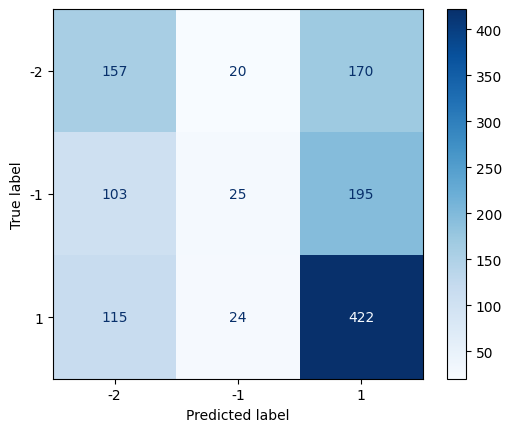

In [119]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(result_test, yhat)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=[-2, -1, 1], )
disp.plot(cmap="Blues")

In [ ]:
test_path_away = '../data/Test_Data/test_away_team_statistics_df.csv'
test_path_home = '../data/Test_Data/test_home_team_statistics_df.csv'
df_attribut_test = prepare_attribut_data(test_path_away, test_path_home,use_player_data=True,is_test=True)
df_attribut_test_id_dropped=df_attribut_test.drop(['ID'], axis=1)
if scaling:
    df_attribut_test_id_dropped = scaler.transform(df_attribut_test_id_dropped)

In [ ]:
df_attribut_test

In [ ]:
yhat_test = LR_best.predict(df_attribut_test_id_dropped)

In [ ]:
y_pred_test = convert_to_one_hot(yhat_test)

In [ ]:
test_prediction = pd.concat([df_attribut_test['ID'], y_pred_test], axis=1)

In [ ]:
test_prediction.to_csv('../submission/logistic_benchmark_submission.csv', index=False)